In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math
from mpl_toolkits import mplot3d

In [9]:
def read_dataset(path=None, train_numbers=0):
    if path is None:
        path = "./midterm"
    subpaths = os.listdir(path)
    dataset = []
    labels = []
    # 读取所有数据并打上标签
    for subpath in subpaths:
        file = open(path + "/" + subpath)
        texts = file.readlines()
        file.close()
        data = [text.split() for text in texts]
        dataset.append(data)
        label = ['class' + subpath[4:5]] * len(data)
        labels.append(label)
    dataset = np.asfarray(dataset)
    # 选择部分数据作为训练数据，部分作为测试数据
    if train_numbers <= 0:
        return dataset, labels
    train_dataset = dataset[:, :train_numbers, :]
    test_dataset = dataset[:, train_numbers:, :]
    train_labels = [labels[i][:train_numbers] for i in range(len(labels))]
    test_labels = [labels[i][train_numbers:] for i in range(len(labels))]
    return (train_dataset, train_labels), (test_dataset, test_labels)

def scatter(data, marker, color, label):
    if data.shape[1] == 2:
        data = data.T
    plt.scatter(data[0], data[1], marker=marker, color=color, label=label)
    plt.legend()

def scatter_all_cate(dataset, labels, colors, nums=None):
    if nums is None:
        nums = len(dataset[0])
    for i in range(len(dataset)):
        scatter(dataset[i][:nums], '+', colors[i], labels[i][0])

def show_density(dataset, densities):
    densities = np.expand_dims(densities, axis=-1)
    fig = plt.figure(figsize=(12,10))
    ax1 = plt.axes(projection='3d')
    for i in range(3):
        zd = densities[i].T
        xd = dataset[i][:, 0:1].reshape(zd.shape)
        yd = dataset[i][:, 1:2].reshape(zd.shape)
        ax1.scatter(xd, yd, zd, c=colors[i])

In [10]:
class Parzen:

    def fit(self, train_dataset, train_labels, n=None):
        """
        train_dataset: (num, len, 2) ndarray
        train_labels: (num, len) list
        n: int
        h: int
        """
        if n is None:
            n = len(train_dataset[0])
        # 估计训练数据的概率密度
        self.cates = [label[0] for label in train_labels]
        self.train_dataset = train_dataset.copy()
        self.train_labels = train_labels.copy()
        self.densities = []
        for train_data in train_dataset:
            data1 = np.expand_dims(train_data, axis=1)
            data1 = np.tile(data1, [1, n, 1])
            # print(data1.shape)
            data2 = np.tile(train_data[:n], [len(train_data), 1, 1])
            xs = data1 - data2
            density = np.sum(np.array([self.kernel(x) for x in xs]), axis=(-1, -2)) / n
            density = density
            self.densities.append(density)
        self.train_densities = np.array(self.densities)
        # 先验概率
        self.prior = dict([(label, prob) for label, prob in zip(self.cates, [1/3]*3)])
        return self.train_densities
        
    def predict(self, test_dataset, test_labels=None, n=None):
        """
        test_dataset:(3, len, 2) ndarray
        test_labels: (3, len) list
        """
        if n is None:
            n = len(self.train_dataset[0])
        self.n = n
        # 矩阵计算
        densities = []
        results = []
        for test_data in test_dataset:
            prob = []
            for train_data in self.train_dataset:
                test = np.expand_dims(test_data, axis=1)
                test = np.tile(test, [1, self.n, 1])
                train = np.tile(train_data[: self.n], [len(test_data), 1, 1])
                xs = test - train
                ps = np.sum(np.array([self.kernel(x) for x in xs]), axis=(-1, -2)) / self.n
                prob.append(ps)
            prob = np.array(prob)  # (3, 1000)
            # 计算后验概率
            post = prob * (np.array([[self.prior[cate] for cate in self.cates]]).T)
            # 选择最大后验概率作为结果
            result = np.argmax(post, axis=0)
            results.append(result)
        result_labels = [[self.cates[i] for i in result.flatten()] for result in results]
        # self.test_densities = np.array(densities)
        
        if test_labels is None:
            # 只需预测，不需给出统计数据
            return result_labels
        else:
            # 给出误判率等统计数据
            numeric_labels = [[self.cates.index(label) for label in labels] for labels in test_labels]
            numeric_labels = np.array(numeric_labels)
            results = np.array(results).reshape(numeric_labels.shape)
            differ = results - numeric_labels
            mis = [np.count_nonzero(dif) / dif.size for dif in differ ]
            total_mis = sum(mis) / len(mis)
            mis = dict([(label, mis) for (label, mis) in zip(self.cates, mis)])
            return result_labels, mis, total_mis

    def kernel(self, x):
        """
        二维标准正态分布
        x: (len, 2)
        return: (len, 1)
        """
        scale = 1 / (2 * math.pi)
        index = -0.5 * np.array([u.T.dot(u) for u in x])
        return scale * np.exp(index).reshape((len(x), 1))

In [11]:
class Knn:
    def __init__(self, k):
        self.k = k

    def fit(self, train_dataset, train_labels):
        self.cates = [label[0] for label in train_labels]
        # 将训练数据复制、展开
        self.train_dataset = np.concatenate(train_dataset, axis=0)  # (len, 2)
        self.train_labels = sum(train_labels, [])               # (len, )
        self.num_train_labels = np.array([self.cates.index(l) for l in self.train_labels])

    def predict(self, test_dataset, test_labels=None):
        # 处理所有种类的测试数据
        results = []
        for test_data in test_dataset:
            # 对每一单个测试数据，计算其与所有训练数据的距离
            result = []
            distance = []
            counts = []
            for one_data in test_data:
                # 欧氏距离
                diff = self.train_dataset - one_data
                dist = np.linalg.norm(diff, axis=1)
                distance.append(dist)
                # 距离从小到大排序的下标
                ascend_idx = np.argsort(dist)
                # 取前k个
                idx = ascend_idx[: self.k]
                # 计数，count[i] / k 即为 p (wi | x) 后验概率
                # 简化计算，只比较个数，即只比较count[i]
                count = np.zeros((len(self.cates))) # （3, )
                for item in self.num_train_labels[idx]:
                    count[item] += 1
                counts.append(count)
                # 选择最大后验概率，即计数最多者
                result.append(np.argmax(count))
            results.append(result)
        result_labels = [[self.cates[i] for i in result] for result in results]
        if test_labels is None:
            # 只需预测，不需给出统计数据
            return result_labels
        else:
            # 给出误判率等统计数据
            numeric_labels = [[self.cates.index(label) for label in labels] for labels in test_labels]
            numeric_labels = np.array(numeric_labels)
            results = np.array(results).reshape(numeric_labels.shape)
            # 正确的标签值相同，相减后为0，统计非0值得个数，即为错误率
            differ = results - numeric_labels
            mis_class = [np.count_nonzero(dif) / dif.size for dif in differ ]
            total_mis = sum(mis_class) / len(mis_class)
            mis = dict([(label, mis) for (label, mis) in zip(self.cates, mis_class)])
            return result_labels, mis, total_mis

Parzen Window(n=1000)各类别误判率： {'class1': '14.90%', 'class2': '1.90%', 'class3': '13.30%'}
总误判率： 10.03%


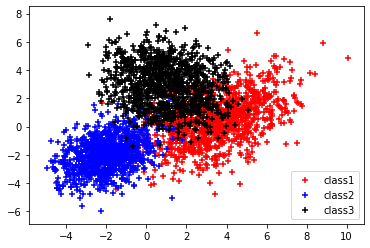

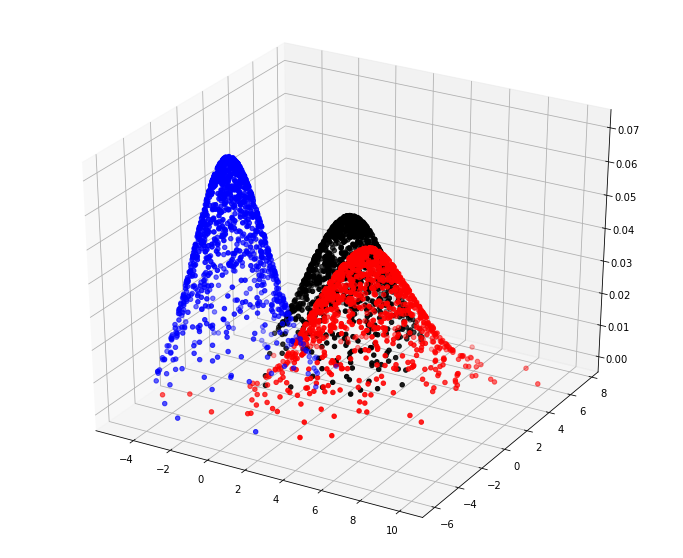

In [15]:
(train_dataset, train_labels), (test_dataset, test_labels) = read_dataset(train_numbers=1000)
colors = ('red', 'blue', 'black')
scatter_all_cate(train_dataset, train_labels, colors)
p1 = Parzen()
densities = p1.fit(train_dataset, train_labels, n=1000)
results, mis, total_mis = p1.predict(test_dataset, test_labels, n=1000)
show_density(train_dataset, densities)
print("Parzen Window(n=1000)各类别误判率：", dict([(k, "{:.2%}".format(v)) for k, v in mis.items()]))
print("总误判率：", "{:.2%}".format(total_mis))

In [13]:
knn1 = Knn(1)
knn1.fit(train_dataset, train_labels)
results, mis, total_mis = knn1.predict(test_dataset, test_labels)
print("Knn(k=1)各类别误判率：", dict([(k, "{:.2%}".format(v)) for k, v in mis.items()]))
print("总误判率：", "{:.2%}".format(total_mis))

Knn(k=1)各类别误判率： {'class1': '19.30%', 'class2': '4.90%', 'class3': '16.90%'}
总误判率： 13.70%


In [14]:
knn10 = Knn(10)
knn10.fit(train_dataset, train_labels)
results, mis, total_mis = knn10.predict(test_dataset, test_labels)
print("Knn(k=10)各类误判率：", dict([(k, "{:.2%}".format(v)) for k, v in mis.items()]))
print("总误判率：", "{:.2%}".format(total_mis))

Knn(k=10)各类误判率： {'class1': '14.20%', 'class2': '2.50%', 'class3': '15.00%'}
总误判率： 10.57%
